In [1]:
%cd ../../..

/home/eli/AnacondaProjects/surprisal_regression


In [2]:
import hydra
import math
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
import pyro
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [3]:
from src.models.components.linear_regression import TrialwiseLinearRegression
import src.eval as evaluation

In [4]:
with hydra.initialize(version_base="1.3", config_path="../../../configs", job_name="eval"):
    cfg = hydra.compose(config_name="eval.yaml", overrides=["ckpt_path=logs/train/runs/2025-04-01_06-35-57/checkpoints/last.ckpt", "data.session_path=/mnt/data/surprisal_coding/epoched/glo_mua_epoched_8.mat",
                        "data.area=V4", "model.importance.ablations=['repetition']"], return_hydra_config=True)
    hydra.core.hydra_config.HydraConfig.instance().set_config(cfg)
    _, objects = evaluation.evaluate(cfg)

[rank: 0] No logger configs found! Skipping...
[striatum:800809] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.striatum.1000/jf.0/1186136064/shared_mem_cuda_pool.striatum could be created.
[striatum:800809] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at logs/train/runs/2025-04-01_06-35-57/checkpoints/last.ckpt
/home/eli/miniforge3/envs/ephys/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["EarlyStopping{'monitor': 'val/loss', 'mode': 'min'}", "ModelCheckpoint{'monitor': 'val/loss', 'mode': 'min', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': Non

Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test/log_evidence     │     -5207.57373046875     │
│    test/log_likelihood    │    -26.638887405395508    │
│         test/loss         │     6973.31298828125      │
└───────────────────────────┴───────────────────────────┘

In [5]:
with torch.no_grad():
    originals = []
    reconstructions = []
    regressor = []
    rvs = {}
    
    for b, (muae, regressors) in tqdm(enumerate(objects['datamodule'].test_dataloader())):
        _, predictions, _, trace = objects['model'].model_step((muae, regressors))
    
        originals.append(muae)
        reconstructions.append(predictions.mean(dim=0))
        regressor.append(regressors)
        for rv in trace.nodes:
            if trace.nodes[rv]['type'] == 'sample':
                if rv in rvs:
                    rvs[rv] = torch.cat((rvs[rv], trace.nodes[rv]['value']), dim=1)
                else:
                    rvs[rv] =  trace.nodes[rv]['value']


    originals = torch.cat(originals, dim=0)
    reconstructions = torch.cat(reconstructions, dim=0)
    regressors = torch.cat(regressor, dim=0)

8it [00:00, 10.99it/s]


In [6]:
def lo_trials():
    return torch.isclose(regressors[:, :, 3], -torch.tensor([[1, 1, 1, 0.8]], dtype=torch.double).log2()).all(dim=-1).argwhere().flatten(0, 1)

def go_trials():
    return torch.isclose(regressors[:, :, 3], -torch.tensor([[1, 1, 1, 0.2]], dtype=torch.double).log2()).all(dim=-1).argwhere().flatten(0, 1)

def rndctrl_trials():
    return torch.isclose(regressors[:, :, 3], -torch.tensor([[0.5, 0.5, 0.5, 0.5]], dtype=torch.double).log2()).all(dim=-1).argwhere().flatten(0, 1)

def seqctrl_trials():
    return torch.isclose(regressors[:, :, 3], -torch.tensor([[1., 1., 1., 1.]], dtype=torch.double).log2()).all(dim=-1).argwhere().flatten(0, 1)

In [7]:
def comparison_plot(trials):
    heights = []
    all_originals = originals[trials, :].mean(dim=0)
    all_reconstructions = reconstructions[trials, :].mean(dim=0)

    for p in range(4):
        heights = heights + [all_originals[p].item(), all_reconstructions[p].item()]

    plt.bar(["P1", "P1'", "P2", "P2'", "P3", "P3'", "P4", "P4'"], heights, color=[('b', 1.), ('b', 0.4), ('b', 1.), ('b', 0.4), ('b', 1.), ('b', 0.4), ('b', 1.), ('b', 0.4)])

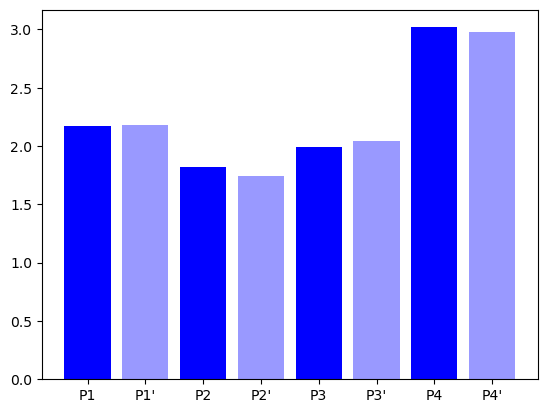

In [8]:
comparison_plot(lo_trials())

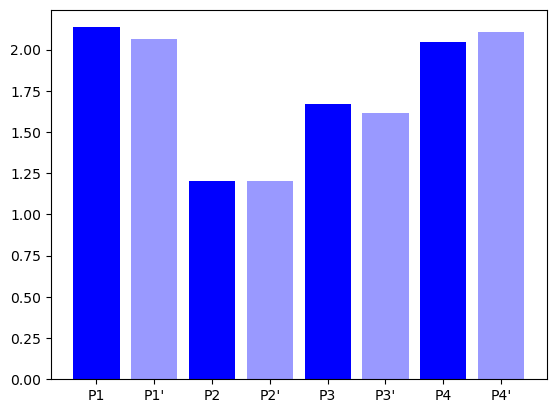

In [9]:
comparison_plot(go_trials())

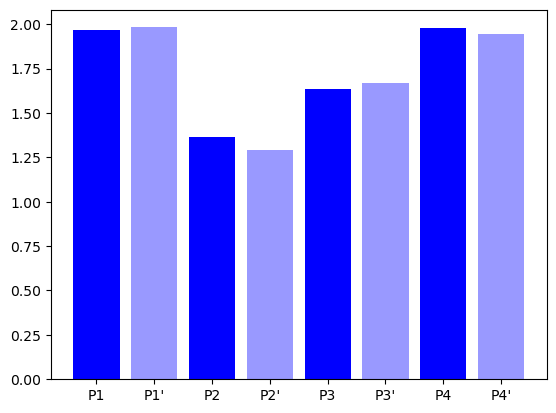

In [10]:
comparison_plot(rndctrl_trials())

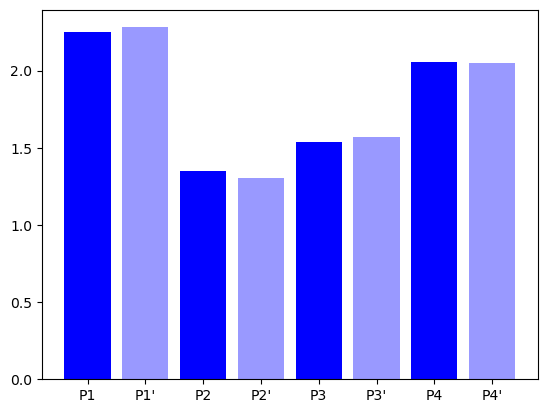

In [11]:
comparison_plot(seqctrl_trials())